In [1]:
import read_muram as rmu
import dp_plot_tools as dplt
import muram_eos as eos
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

dplt.plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
dplt.plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
dplt.plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
dplt.plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
dplt.plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
dplt.plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
dplt.plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Importing read_muram.py
Importing dp_plot_tools.py
Importing muram_eos.py


In [2]:
## Load the EOS file
eos_file = "../RUNDIR/Uppsala_mergedeos_PI_A.dat"
mu_eos=eos.mu_eos(eos_file)

In [27]:
#load snapshot
dir = '/scratch/przybylski/2D_SCATTER_TESTS/checkerboard/'
iter = 72000
atmos_low = rmu.MURaM_snap(dir)
atmos_low.load(str(iter).zfill(6),tooload=['vx', 'vy', 'vz', 'eps', 'bx', 'by', 'bz', 'rho','tem','pre','tau'])

218000000.0 0.7295366 217055097.12088868


217055097.12088868

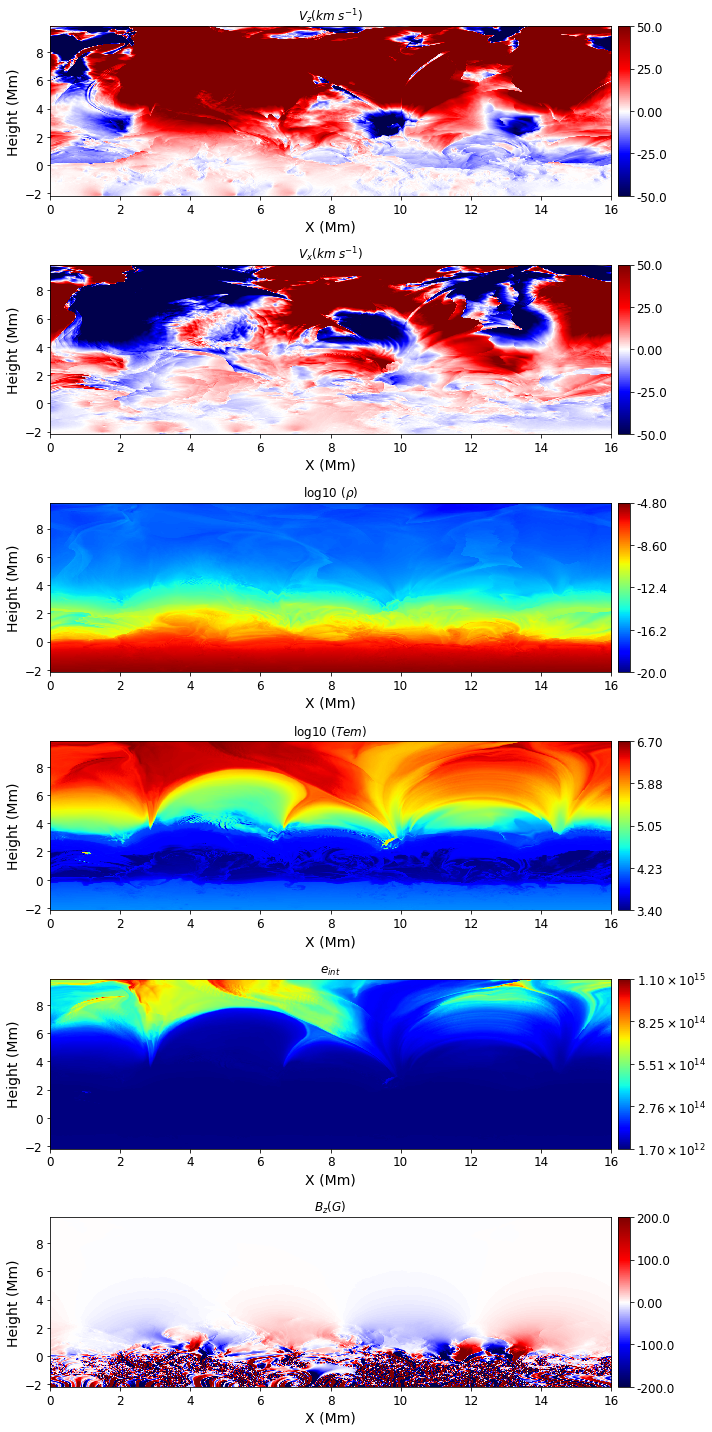

In [28]:
xax = [atmos_low.gxmin[0]/1.0e8,atmos_low.gxmax[0]/1.0e8]
yax = [atmos_low.gxmin[2]/1.0e8,atmos_low.gxmax[2]/1.0e8]

xt='X (Mm)'
yt = 'Height (Mm)'

[fig,gs] = dplt.fig_open(figsize=[10,20],numx=1,numy=6)
dplt.plotsnapshot(fig,np.clip(atmos_low.vz.squeeze()*1.0e-5,-50.0,50.0),pos=gs[0],xax=xax,yax=yax,sym=True,cmap='seismic',title = r'$V_z (km\; s^{-1})$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.clip(atmos_low.vx.squeeze()*1.0e-5,-50.0,50.0),pos=gs[1],xax=xax,yax=yax,sym=True,cmap='seismic',title= r'$V_x (km\; s^{-1})$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.log10(atmos_low.rho.squeeze()),pos=gs[2],xax=xax,yax=yax,title = r'log10 $(\rho)$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.log10(atmos_low.tem.squeeze()),pos=gs[3],xax=xax,yax=yax,title = r'log10 $(Tem)$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,atmos_low.eps.squeeze(),pos=gs[4],xax=xax,yax=yax,sym=False,title = r'$e_{int}$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.clip(atmos_low.bz.squeeze(),-200,200),pos=gs[5],xax=xax,yax=yax,sym=True,cmap='seismic', title = r'$B_z (G)$',xtitle=xt,ytitle=yt)
gs.tight_layout(fig)

In [5]:
## Set the simulation size and range
## Nz = vertical direction (dimension 0 in MURaM)

## Point at which the extrapolation will be started
Nz_top=390

#Old Nz
Nz_old = atmos_low.nz

#Extended Nz
Nz = 1200

Nz_dif = Nz-Nz_top

## Nx = first horizontal direction (set = 1 for 1D)
## Ny = second horizontal direection (set = 1 for 2D or 1D)

Nx = atmos_low.nx
Ny = atmos_low.ny

# dx,dy,dz

dx = atmos_low.dx
dy = atmos_low.dy
dz = atmos_low.dz

## box_top = the top height above the surface in Mm
## box_range = the vertical extend in Mm
box_top = Nz*dz
box_top_old = Nz_top*dz

## Extension size at which extension starts
z_width = Nz_dif*dz
 
#temperature at upper boundary
t_fin = 1.0e6

## Output Directory
out_iter = '000000'
out_dir = '/scratch/przybylski/2D_SCATTER_TESTS/checkerboard_extend/'

In [6]:
## Arrays to interpolate for rho, pressure and density
r_bkg = np.zeros([Nz-Nz_top])
p_bkg = np.zeros([Nz-Nz_top])
t_bkg = np.zeros([Nz-Nz_top])

## Scale height H_bkg (not constant in this case)
H_bkg = np.zeros([Nz-Nz_top])

## Internal Energy
e_bkg=np.zeros([Nz-Nz_top])

#Values at the upper boundary of original box
r0 = atmos_low.rho[:,:,Nz_top-1].mean()
p0 = atmos_low.pre[:,:,Nz_top-1].mean()
t0 = atmos_low.tem[:,:,Nz_top-1].mean()

In [7]:
## Temperature extension behaves like tanh
## no constant scale height anymore

## Compute temperature extension

H_bkg[0] = p0/r0/2.74e4

for kk in range(Nz-Nz_top):
    dif = (kk+1)*dz/z_width
    tanval = np.tanh(dif*2.*np.pi-np.pi)
    t_bkg[kk] = t0 + (t_fin - t0)*(0.5+tanval*0.5)

## Scale height at lower boundary
for kk in range(Nz-Nz_top):
    intHp = np.exp(-(np.sum(dz/H_bkg[0:kk])))
    r_bkg[kk] = r0*t0/t_bkg[kk]*intHp
    p_bkg[kk] = p0*intHp                         
    H_bkg[kk] = (p_bkg[kk]/r_bkg[kk]/2.74e4)
    
## Invert temperature table for internal energy

for kk in range(Nz-Nz_top):
    T_array = mu_eos.interp_T(np.exp(mu_eos.xeps)-mu_eos.eps_off,np.tile(r_bkg[kk],mu_eos.n_eps))
    Tisnan = np.isnan(T_array)
    e_bkg[kk]= np.exp(np.interp(t_bkg[kk],T_array[~Tisnan],mu_eos.xeps[~Tisnan]))-mu_eos.eps_off
    
print(e_bkg[-1])    

214333496693813.56


In [8]:
## Get ready for FFT potential field extrapolation
res = 16

heightscale = dz/dx

Nxs = Nx*res
Nys = Ny*res

bx_extend = np.zeros([Nx,Ny,Nz])
by_extend = np.zeros([Nx,Ny,Nz])
bz_extend = np.zeros([Nx,Ny,Nz])

bx_extend[:,:,0:Nz_old] = atmos_low.bx
by_extend[:,:,0:Nz_old] = atmos_low.by
bz_extend[:,:,0:Nz_old] = atmos_low.bz

## Define Fourier grid

kx = np.zeros([Nxs])
ky = np.zeros([Nys])

kx[0:Nxs//2] = np.arange(Nxs//2)/Nxs
kx[Nxs//2:Nxs] = np.arange(Nxs//2)/Nxs-0.5

kx=np.array([kx[:],]*Nys).transpose()  
kx *= 2*np.pi

if Ny > 1:
    ky[0:Nys//2] = np.arange(Nys//2)/Nys
    ky[Nys//2:] = np.arange(Nys//2)/Nys-0.5

ky = np.array([ky[:],]*Nxs)
ky *= 2*np.pi

k2 = kx*kx + ky*ky
kabs = np.sqrt(k2)

## Define Fourier grid

kx = np.zeros([Nxs])
ky = np.zeros([Nys])

kx[0:Nxs//2] = np.arange(Nxs//2)/Nxs
kx[Nxs//2:Nxs] = np.arange(Nxs//2)/Nxs-0.5

kx=np.array([kx[:],]*Nys).transpose()  
kx *= 2*np.pi

if Ny > 1:
    ky[0:Nys//2] = np.arange(Nys//2)/Nys
    ky[Nys//2:] = np.arange(Nys//2)/Nys-0.5

ky = np.array([ky[:],]*Nxs)
ky *= 2*np.pi

k2 = kx*kx + ky*ky
kabs = np.sqrt(k2)

## Define Fourier grid

kx = np.zeros([Nxs])
ky = np.zeros([Nys])

kx[0:Nxs//2] = np.arange(Nxs//2)/Nxs
kx[Nxs//2:Nxs] = np.arange(Nxs//2)/Nxs-0.5

kx=np.array([kx[:],]*Nys).transpose()  
kx *= 2*np.pi

if Ny > 1:
    ky[0:Nys//2] = np.arange(Nys//2)/Nys
    ky[Nys//2:] = np.arange(Nys//2)/Nys-0.5

ky = np.array([ky[:],]*Nxs)
ky *= 2*np.pi

k2 = kx*kx + ky*ky
kabs = np.sqrt(k2)

## Complex Arrays
HxB = np.zeros([Nxs,Nys],dtype=np.complex)
HyB = np.zeros([Nxs,Nys],dtype=np.complex)
HzB = np.ones([Nxs,Nys],dtype=np.complex)

HxB[np.where(k2 != 0)] = -1j*kx[np.where(k2 != 0)]/kabs[np.where(k2 != 0)]
HxB[0,0] = -1j

if Ny == 1:
    HxB[0,:] = -1j

HyB[np.where(k2 != 0)] = -1j*ky[np.where(k2 != 0)]/kabs[np.where(k2 != 0)]
HyB[0,0] = -1j

if Ny == 1:
    HyB[0,:] = -1j

## Delta Function

delta = np.zeros([Nxs,Nys])

for i in range(-4*res,4*res+1):
    i0 = i
    while i0 < 0:
        i0 = i0+Nxs
    for j in range(-4*res,4*res+1):
        j0=j
        while j0 < 0:
            j0 = j0+Nys
        if Ny == 1:
            delta[i0,:] = np.exp(-np.double(np.fmod(i,Nxs))**2/res**2)
        else:
            delta[i0,j0] = np.exp(-(np.double(np.fmod(i,Nxs))**2+np.double(np.fmod(j,Nys))**2)/res**2)

delta/=delta.sum()

## FFT delta function

FFTdelta = np.fft.fft2(delta)

In [9]:
## define function symmetric rebin

def symmetric_rebin(a, oNx, oNy):
    Nx = a.shape[0]
    Ny = a.shape[1]
    dx = Nx/oNx
    dy = Ny/oNy
    
    dxi = np.int(dx)
    dyi = np.int(dy)
    
    out= np.zeros([oNx,oNy])
    b = np.zeros([Nx+2*dxi,Ny+2*dyi])
    
    b[dxi:dxi+Nx,dyi:dyi+Ny] = a
    
    ## Fill y ghost cells
    b[0:dxi,dyi:Ny+dyi] = a[Nx-dxi:Nx,0:Ny]
    b[Nx+dxi:Nx+2*dxi,dyi:Ny+dyi] = a[0:dxi,0:Ny]
    
    ## Fill x ghost cells
    b[:,0:dyi] = b[:,Ny:Ny+dyi]
    b[:,Ny+dyi:Ny+2*dyi] = b[:,dyi:2*dyi]

    cx = np.int(dx/2)
    cy = np.int(dy/2)
    
    for i in range(dxi,Nx+dxi,dxi):
        for j in range(dyi,Ny+dyi,dyi):
            out[i//dxi-1,j//dyi-1] = b[i-cx:i+cx+1,j-cy:j+cy+1].sum()
            
    return out

In [10]:
## Start a few cells in from the boundary to ensure smoothness
b0 = bz_extend[:,:,Nz_top]

## Make Kernel and Convolve
xbkernel = np.zeros([Nx,Ny])
ybkernel = np.zeros([Nx,Ny])
zbkernel = np.zeros([Nx,Ny])

for k in range(Nz_top,Nz):
    z = (k-Nz_top)*heightscale*res
    
    xbkernel[:,:] = symmetric_rebin(np.fft.ifft2(FFTdelta*HxB*np.exp(-kabs*z)).real,Nx,Ny)
    ybkernel[:,:] = symmetric_rebin(np.fft.ifft2(FFTdelta*HyB*np.exp(-kabs*z)).real,Nx,Ny)
    zbkernel[:,:] = symmetric_rebin(np.fft.ifft2(FFTdelta*HzB*np.exp(-kabs*z)).real,Nx,Ny)
    
    flux = zbkernel[:,:].sum()
    
    xbkernel/=flux
    ybkernel/=flux
    zbkernel/=flux
    
    bx_extend[:,:,k] = np.fft.ifft2(np.fft.fft2(b0)*np.fft.fft2(xbkernel[:,:])).real
    by_extend[:,:,k] = np.fft.ifft2(np.fft.fft2(b0)*np.fft.fft2(ybkernel[:,:])).real
    bz_extend[:,:,k] = np.fft.ifft2(np.fft.fft2(b0)*np.fft.fft2(zbkernel[:,:])).real

In [11]:
divB = np.zeros([Nx,Ny,Nz])
divB += rmu.deriv_3d_O4(bx_extend,0,dx,periodic=True)
if (Ny > 1):
    divB += rmu.deriv_3d_O4(by_extend,1,dy,periodic=True)
divB += rmu.deriv_3d_O4(bz_extend,2,dz,periodic=False)
divB/=np.sqrt(bx_extend*bx_extend+by_extend*by_extend+bz_extend*bz_extend)

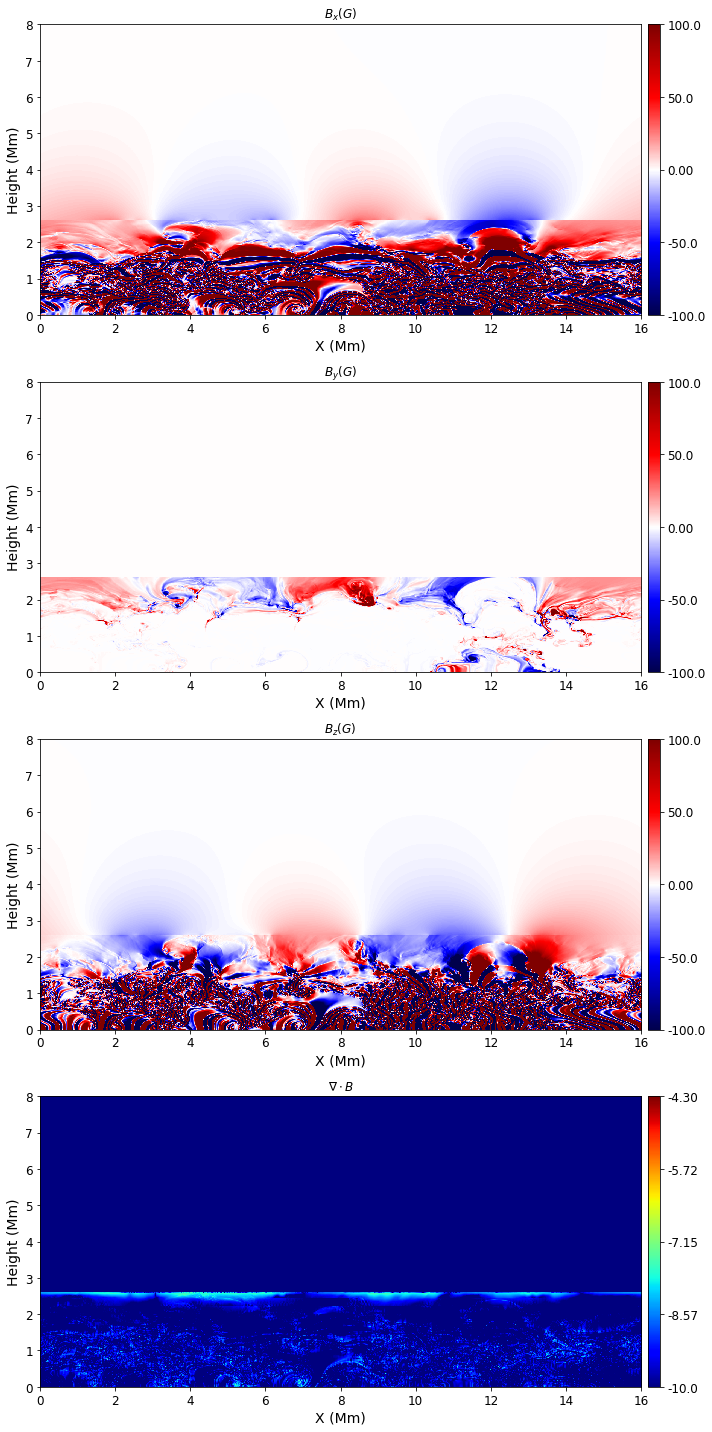

In [12]:
xax = [0.0,16.0]
yax = [0.0,8.0]
xt='X (Mm)'
yt = 'Height (Mm)'

[fig,gs] = dplt.fig_open(figsize=[10,20],numx=1,numy=4)
dplt.plotsnapshot(fig,np.clip(bx_extend[:,Ny//2,:].squeeze(),-100,100),pos=gs[0],xax=xax,yax=yax,sym=True,cmap='seismic',title = r'$B_x (G)$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.clip(by_extend[:,Ny//2,:].squeeze(),-100,100),pos=gs[1],xax=xax,yax=yax,sym=True,cmap='seismic',title= r'$B_y (G)$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.clip(bz_extend[:,Ny//2,:].squeeze(),-100,100),pos=gs[2],xax=xax,yax=yax,sym=True,cmap='seismic',title= r'$B_z (G)$',xtitle=xt,ytitle=yt)
dplt.plotsnapshot(fig,np.log10(np.clip(np.abs(divB[:,Ny//2,:].squeeze()),1.0e-10,None)),pos=gs[3],xax=xax,yax=yax,title = r'$\nabla \cdot B$',xtitle=xt,ytitle=yt)
gs.tight_layout(fig)

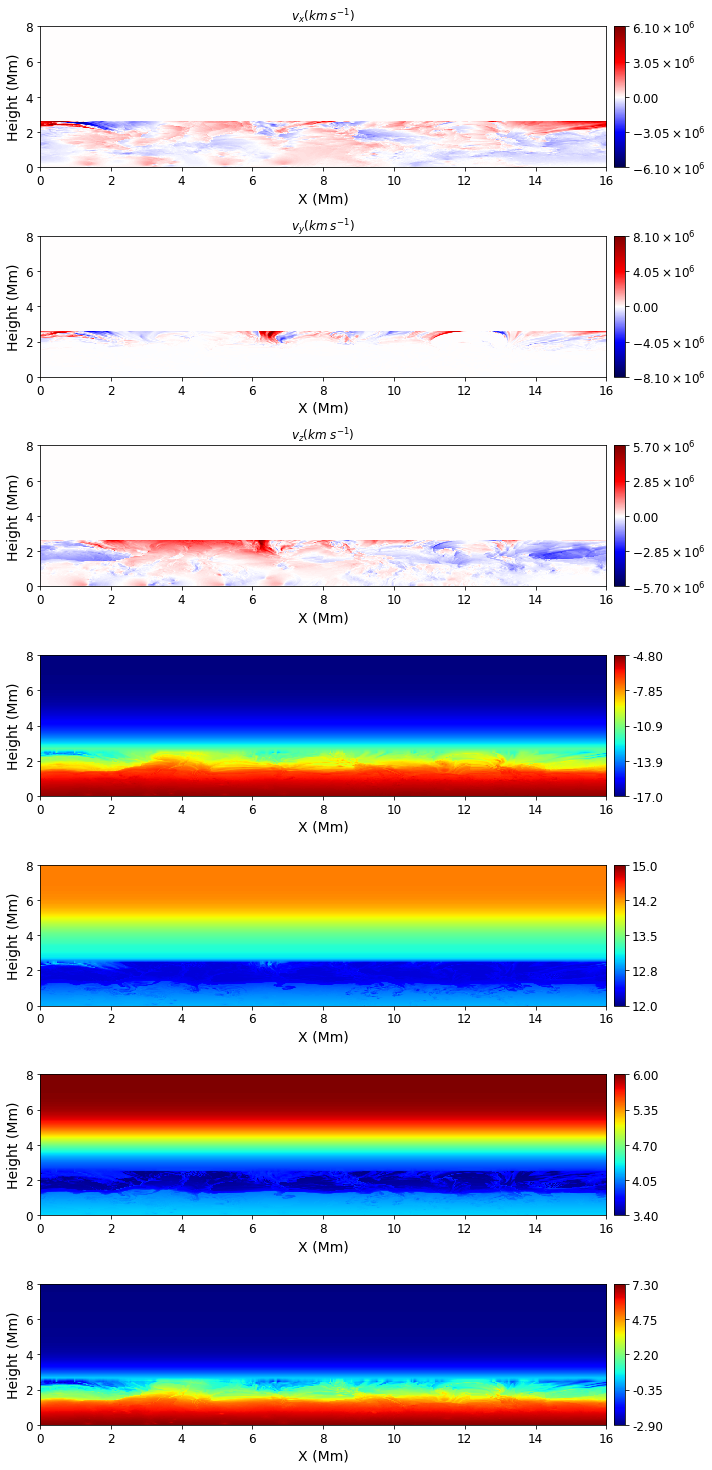

In [15]:
## append arrays cut slice for figure and save
## Velocities are simple, just set to 0:

[fig,gs] = dplt.fig_open(figsize=[10,20],numx=1,numy=7)

temp_arr=np.append(atmos_low.vx[:,:,:Nz_top],np.zeros([Nx,Ny,Nz-Nz_top]), axis = 2)
temp_arr.astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_2.'+str(out_iter).zfill(6))

dplt.plotsnapshot(fig,temp_arr[:,Ny//2,:].squeeze(),pos=gs[0],xax=xax,yax=yax,sym=True,cmap='seismic',title = r'$v_x (km\; s^{-1})$',xtitle=xt,ytitle=yt)

temp_arr=np.append(atmos_low.vy[:,:,:Nz_top],np.zeros([Nx,Ny,Nz-Nz_top]), axis = 2)
temp_arr.astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_3.'+str(out_iter).zfill(6))

dplt.plotsnapshot(fig,temp_arr[:,Ny//2,:].squeeze(),pos=gs[1],xax=xax,yax=yax,sym=True,cmap='seismic',title= r'$v_y (km\; s^{-1})$',xtitle=xt,ytitle=yt)

temp_arr=np.append(atmos_low.vz[:,:,:Nz_top],np.zeros([Nx,Ny,Nz-Nz_top]), axis = 2)
temp_arr.astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_1.'+str(out_iter).zfill(6))

dplt.plotsnapshot(fig,temp_arr[:,Ny//2,:].squeeze(),pos=gs[2],xax=xax,yax=yax,sym=True,cmap='seismic',title= r'$v_z (km\; s^{-1})$',xtitle=xt,ytitle=yt)
  
## Now for thermodynamics
rho = np.append(atmos_low.rho[:,:,:Nz_top],np.tile(r_bkg,(Nx,Ny,1)), axis = 2) 
for ii in range(Nx):
    for jj in range(Ny):
        for kk in range(Nz_top-19,Nz_top+10):
            rho[ii,jj,kk] = np.exp(np.log(rho[ii,jj,Nz_top-20])+(np.log(rho[ii,jj,Nz_top+10])-np.log(rho[ii,jj,Nz_top-20]))/(Nz_top+10-(Nz_top-20))*(kk-(Nz_top-20)))

rho.astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_0.'+str(out_iter).zfill(6))
dplt.plotsnapshot(fig,np.log10(rho[:,Ny//2,:].squeeze()),pos=gs[3],xax=xax,yax=yax,xtitle=xt,ytitle=yt)

eps = np.append(atmos_low.eps[:,:,:Nz_top], np.tile(e_bkg,(Nx,Ny,1)), axis = 2)
for ii in range(Nx):
    for jj in range(Ny):
        for kk in range(Nz_top-19,Nz_top):
            eps[ii,jj,kk] = eps[ii,jj,Nz_top-20]+(eps[ii,jj,Nz_top]-eps[ii,jj,Nz_top-20])/(Nz_top-(Nz_top-20))*(kk-(Nz_top-20))

(rho*eps).astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_4.'+str(out_iter).zfill(6))
dplt.plotsnapshot(fig,np.log10(eps[:,Ny//2,:].squeeze()),pos=gs[4],xax=xax,yax=yax,xtitle=xt,ytitle=yt)
gs.tight_layout(fig)

temp = mu_eos.interp_T(eps,rho)
dplt.plotsnapshot(fig,np.log10(temp[:,Ny//2,:].squeeze()),pos=gs[5],xax=xax,yax=yax,xtitle=xt,ytitle=yt)

pres = mu_eos.interp_p(eps,rho)
dplt.plotsnapshot(fig,np.log10(pres[:,Ny//2,:].squeeze()),pos=gs[6],xax=xax,yax=yax,xtitle=xt,ytitle=yt)

## Finally B-Fields
s4pi = 1.0/np.sqrt(4.0*np.pi)

(bx_extend*s4pi).astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_6.'+str(out_iter).zfill(6))
(by_extend*s4pi).astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_7.'+str(out_iter).zfill(6))
(bz_extend*s4pi).astype(np.single).swapaxes(0,1).ravel().tofile(out_dir+'3D/result_prim_5.'+str(out_iter).zfill(6))

# Heat Flux
np.zeros(Nx*Ny*Nz).astype(np.single).tofile(out_dir+'3D/result_prim_8.'+str(out_iter).zfill(6))

## Header
f=open(out_dir + '3D/Header.'+str(out_iter).zfill(6),'w')
f.write(str(Nz) + "  " + str(Nx) + "  " + str(Ny) + "  " + str(atmos_low.dz) + "  " + str(atmos_low.dx) + "  " + str(atmos_low.dy) + " " + str(atmos_low.time)  + " " + str(atmos_low.dt) + " " + str(2.99792458e10))
f.close()

# Read old backup.dat
backup=np.loadtxt(dir+'backup.dat')

#Backup.dat
f=open(out_dir + 'backup.dat','w')
f.write(str(0) + "  " + str(0.0) + "  " + str(backup[2]) + "  " + str(backup[3]) + "  " + str(np.single(atmos_low.rho.sum()+r_bkg.sum()*Nx*Ny)))
f.close()

In [16]:
print(bz_extend[:,:,Nz_old].sum(),bz_extend[:,:,-1].sum())

print("Rho_min = "+str(r_bkg.min())+" and eps_max = "+ str(e_bkg.max()))

-236.04365893825843 -236.04365893825883
Rho_min = 9.997678566817173e-18 and eps_max = 214333496693813.56
